# Ch04 SeqBootstrap(Tick)

In [111]:
import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime as dt
from adv_finance import bars, labeling, utils, sampling, multiprocess

from tqdm import tqdm
from scipy.sparse import csr_matrix

import matplotlib.pylab as plt
import scipy.sparse as sparse

# import sys
# import multiprocessing as mp
# import time

In [112]:
%load_ext autoreload 
%autoreload 2

plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740_DB.parq')
data = data.loc[~data.index.duplicated(keep='first')]
data = data



In [5]:
%%time
daily_vol = utils.get_daily_vol(data['close'])
threshold = daily_vol.mean() * 0.1
t_events = labeling.cusum_filter(data['close'], threshold)
v_barriers = labeling.add_vertical_barrier(t_events=t_events, close=data['close'], num_days=1)



pt_sl = [1,1]
min_ret = 0.01

t_side_events = labeling.get_events(close=data['close'], 
                                      t_events=t_events, 
                                      pt_sl=pt_sl, 
                                      num_threads=8, 
                                      target=daily_vol, 
                                      min_ret=min_ret, 
                                      vertical_barrier_times = v_barriers, 
                                      side_prediction=None)


/nfs/code/adv_finance/adv_finance/labeling/labeling.py:111: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


CPU times: user 5.29 s, sys: 58.7 ms, total: 5.35 s
Wall time: 29.2 s


2019-05-29 06:53:41.320629 100.0%apply_pt_sl_on_t1 done after 0.4 minutes. Remaining 0.0 minutes.


In [199]:
# d0 = '2018-01-08'
# d0 = '2018-01-04'
d0 = '2018-01-03'
d1 = '2018-01-05'
data0 = data.loc[d0:d1]
t_side_events0 = t_side_events.loc[d0:d1].dropna(subset=['t1'])

In [207]:
data0.shape

(1254, 5)

In [201]:
def get_baridx_t1(bar, t_events): 
    # ind_mat을 만들기 위해 바의 (start, end)의 loc 값을 array로 만들어준다
    list_beg = []
    list_end = []

    for i in t_events.itertuples():
        try: 
            t0_ = bar.index.get_loc(i.Index)
            t1_ = bar.index.get_loc(i.t1)

            list_beg.append(t0_)
            list_end.append(t1_)

        except Exception as e: 
            print(i)


    beg_arr = np.array(list_beg)
    end_arr = np.array(list_end)


    t1 = pd.Series(end_arr, index=beg_arr)
    bar_idx = np.arange(t1.max() + 1)
    return bar_idx, t1


def plot_mat(mat0, figsize, markersize): 
    # plot sparse matrix
    plt.figure(figsize=figsize) 
    plt.title("IndM")
    plt.spy(mat0, precision=0.001, marker='o', markersize=markersize)

    plt.show()

In [202]:
bar_idx, t1 =  get_baridx_t1(data0, t_side_events0)

Pandas(Index=Timestamp('2018-01-05 14:30:07.715000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.011231026730664872)
Pandas(Index=Timestamp('2018-01-05 14:30:17.605000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.011692274895807287)
Pandas(Index=Timestamp('2018-01-05 14:31:52.142000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.013140187277035986)
Pandas(Index=Timestamp('2018-01-05 14:33:04.764000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.013923611013573764)
Pandas(Index=Timestamp('2018-01-05 14:33:57.251000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.014353519821376916)
Pandas(Index=Timestamp('2018-01-05 14:34:13.358000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.014375335638223687)
Pandas(Index=Timestamp('2018-01-05 14:34:58.855000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.014389617885844466)
Pandas(Index=Timestamp('2018-01-05 14:37:13.389000'), t1=Timestamp('2018-01-08 09:00:02.607000'), trgt=0.014531748190699223)


In [203]:
%%time 
ind_m = sampling.get_ind_matrix(bar_idx, t1)


150it [00:00, 536.34it/s]

CPU times: user 293 ms, sys: 8.68 ms, total: 302 ms
Wall time: 282 ms


In [208]:
ind_m.shape

(1180, 150)

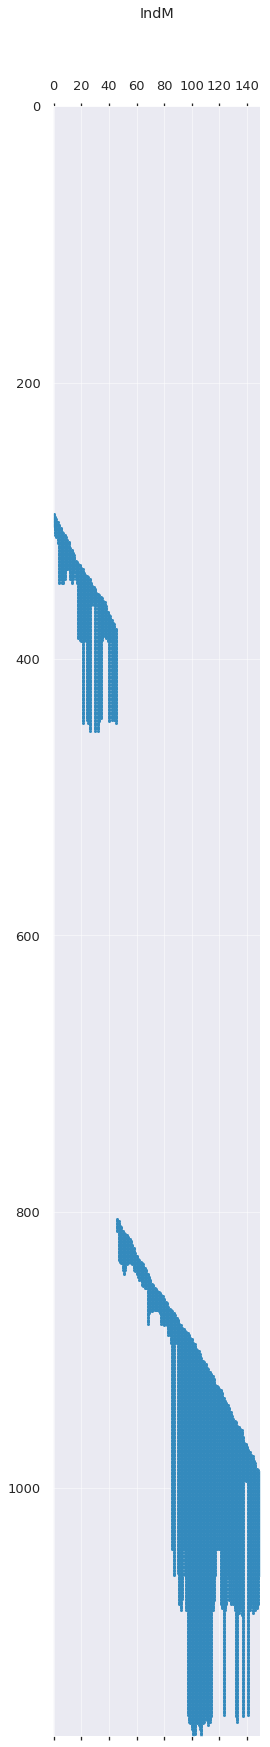

In [204]:
plot_mat(ind_m.todense(), (10, 30), 3)

# SeqBootstrap

In [191]:
def auxMC(bar_idx, t1):
    ind_m = sampling.get_ind_matrix(bar_idx, t1, verbose=False)
    
    phi = sampling.seq_bootstrap(ind_m, verbose=False)
    seq_u = sampling.get_avg_uniqueness(ind_m[:, phi], None).mean()
    
    phi = np.random.choice(np.arange(ind_m.shape[1]), size=ind_m.shape[1])
    std_u = sampling.get_avg_uniqueness(ind_m[:, phi], None).mean()

    return {'std_u': std_u, 'seq_u': seq_u}


def mainMC(bar_idx, t1, num_iters=5, num_threads=1):
    jobs = []
    for i in np.arange(num_iters):
        job = {'func': auxMC, 'bar_idx': bar_idx, 't1': t1}
        jobs.append(job)

    if num_threads == 1:
        out = multiprocess.process_jobs_(jobs)
    else:
        out = multiprocess.process_jobs(jobs, num_threads)

    return pd.DataFrame(out)

In [192]:
import warnings 
warnings.filterwarnings('ignore')


In [196]:
%%time
np.random.seed(42)
df = mainMC(bar_idx, t1, num_iters=1000, num_threads=24)

CPU times: user 17.3 s, sys: 6.51 s, total: 23.8 s
Wall time: 27min 30s


2019-05-29 08:59:37.397814 100.0 24 done after 27.51 minutes. Remaining 0.0 minutes.


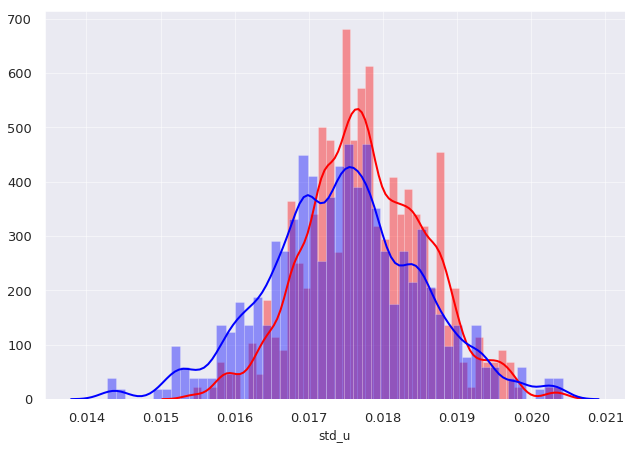

In [198]:
import seaborn as sns 

sns.set_style('darkgrid')
sns.distplot(df['seq_u'], color='red')
sns.distplot(df['std_u'], color='blue')

# APPENDIX

In [159]:
# ind_m = sampling.get_ind_matrix(bar_idx, t1, verbose=False)
m = ind_m.todense()
seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
seq_u = sampling.get_avg_uniqueness(ind_m[:, seq_phi], None).mean()



In [164]:
# plot_mat(m[:, seq_phi], (10, 30), 3)

In [150]:
std_phi = np.random.choice(np.arange(ind_m.shape[1]), size=ind_m.shape[1])
std_u = sampling.get_avg_uniqueness(ind_m[:, std_phi], None).mean()


In [165]:
# plot_mat(m[:, std_phi], (10, 30), 3)

In [166]:
seq_u

0.02748854724183913

In [167]:
std_u

0.02811095349756861